In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
%env DASK_LOGGING__DISTRIBUTED=CRITICAL
%env SPYTMPDIR=/mnt/data/tmp_storage
%env SPYLOGLEVEL=CRITICAL
%env SPYPARLOGLEVEL=CRITICAL

env: DASK_LOGGING__DISTRIBUTED=CRITICAL
env: SPYTMPDIR=/mnt/data/tmp_storage
env: SPYLOGLEVEL=CRITICAL
env: SPYPARLOGLEVEL=CRITICAL


In [3]:
import collections
import functools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import quantities as pq

import epych
from epych.statistics import alignment

[striatum:1499997] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.striatum.1000/jf.0/4198236160/shared_mem_cuda_pool.striatum could be created.
[striatum:1499997] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
ADAPTED_ONSET = pq.Quantity(-1.0) * pq.second
ADAPTED_OFFSET = pq.Quantity(-0.5) * pq.second
ODDBALL_ONSET = pq.Quantity(-1.9017372477960602e-14) * pq.second
ODDBALL_OFFSET = pq.Quantity(0.5004545430388676) * pq.second
EVENTS = {
    "Adapted Onset": (ADAPTED_ONSET.magnitude, 'lightgreen'),
    "Adapted Offset": (ADAPTED_OFFSET.magnitude, 'red'),
    "Oddball Onset": (ODDBALL_ONSET.magnitude, 'lightgreen'),
    "Oddball Offset": (ODDBALL_OFFSET.magnitude, 'red'),
}

In [7]:
CONDITIONS = ["lonaive", "go_gloexp", "go_seqctl", "lo_gloexp", "lo_rndctl", "igo_seqctl"]

In [8]:
area_titles = {
    "VISal": "AL",
    "VISam": "AM",
    "VISl": "LM",
    "VISp": "V1",
    "VISpm": "PM",
    "VISrl": "RL",
}
def stattitle(name, stat):
    if name in area_titles:
        return area_titles[name]
    return name
anatomical_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

In [9]:
def initialize_spectrum(key, signal, path=None):
    area = os.path.commonprefix([loc for loc in signal.channels.location])
    return epych.statistics.spectrum.Spectrogram(signal.df, signal.channels, signal.f0, chunk_trials=3, taper="hann", path=path + "/" + key)

In [10]:
spectrograms = {}

In [11]:
for cond in CONDITIONS:
    cond_path = "/mnt/data/000253/grand_spectrogram_downsample32_%s" % cond
    spectrograms[cond] = epych.statistic.Summary.unpickle(cond_path, epych.statistics.spectrum.Spectrogram)
    logging.info("Loaded LFP spectrograms across condition %s" % cond)

INFO:root:Loaded LFP spectrograms across condition lonaive
INFO:root:Loaded LFP spectrograms across condition go_gloexp
INFO:root:Loaded LFP spectrograms across condition go_seqctl
INFO:root:Loaded LFP spectrograms across condition lo_gloexp
INFO:root:Loaded LFP spectrograms across condition lo_rndctl
INFO:root:Loaded LFP spectrograms across condition igo_seqctl


In [12]:
PVALUE = 1e-2

In [13]:
CONTRASTS = [("logo", "lo_gloexp", "go_gloexp"), ("go_contrast", "go_gloexp", "go_seqctl"), ("lo_contrast", "lo_gloexp", "lo_rndctl"),
             ("ssa", "lo_gloexp", "igo_seqctl"), ("dd", "lo_rndctl", "lonaive")]

In [14]:
def initialize_grand_cluster_test(key, signals):
    return epych.statistics.grand.GrandNonparametricClusterTest(signals[0].num_channels, len(signals[0].times), alpha=PVALUE, partitions=1000)

In [15]:
contrasts = {}

In [16]:
def baselined_spectrogram(spectrogram):
    return spectrogram.result().channel_mean().baseline(-3.5 * pq.second, -3.0 * pq.second)

In [17]:
def area_name(probe, signals):
    return probe

In [18]:
for (name, condl, condr) in CONTRASTS:
    contrasts[name] = epych.statistic.Summary(area_name, initialize_grand_cluster_test)
    contrast_signals = {k: (baselined_spectrogram(spectrograms[condl].stats[k]), baselined_spectrogram(spectrograms[condr].stats[k]))
                        for k in spectrograms[condl].stats.keys()}
    contrasts[name].calculate([contrast_signals])
    logging.info("Nonparametrically contrasted spectrograms for %s" % name)

INFO:root:Nonparametrically contrasted spectrograms for logo
INFO:root:Nonparametrically contrasted spectrograms for go_contrast
INFO:root:Nonparametrically contrasted spectrograms for lo_contrast
INFO:root:Nonparametrically contrasted spectrograms for ssa
INFO:root:Nonparametrically contrasted spectrograms for dd


In [19]:
for (name, _, _) in CONTRASTS:
    contrasts[name].pickle("/mnt/data/DRAFT/000253/spectrogram_contrasts_" + name + '_01')

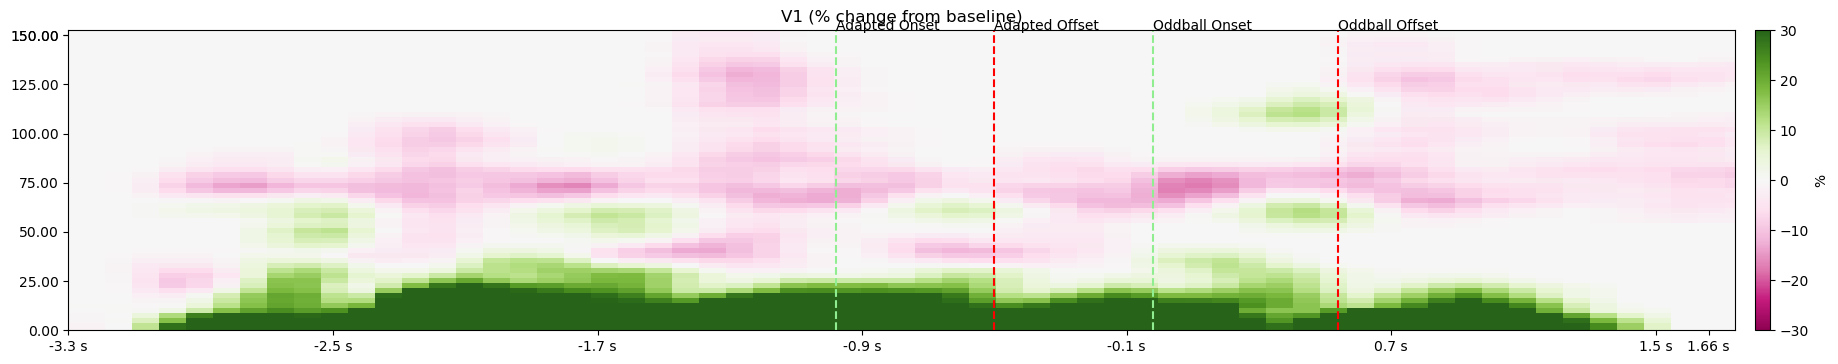

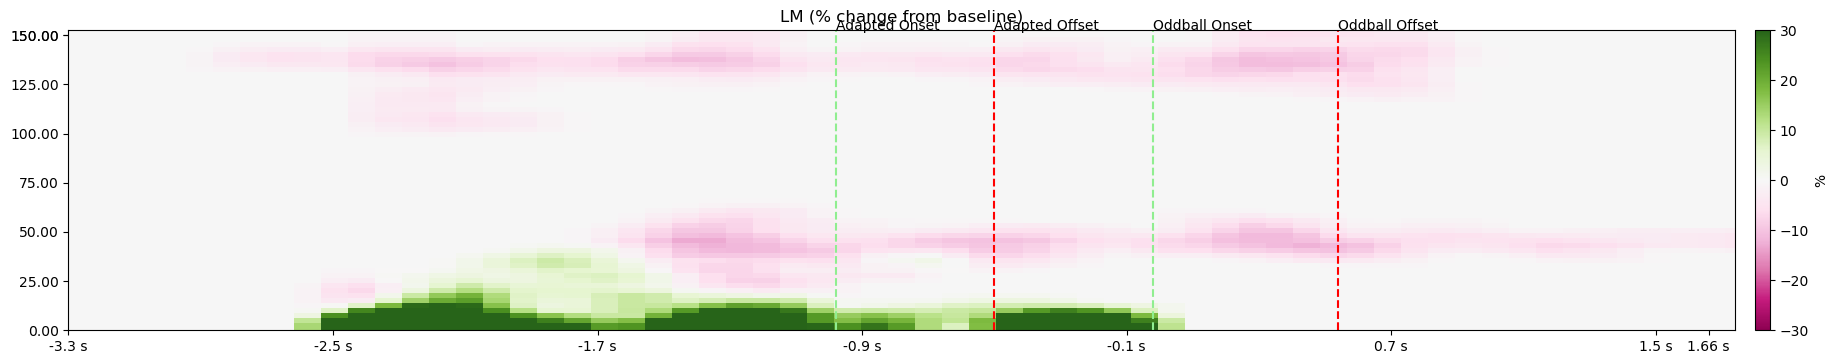

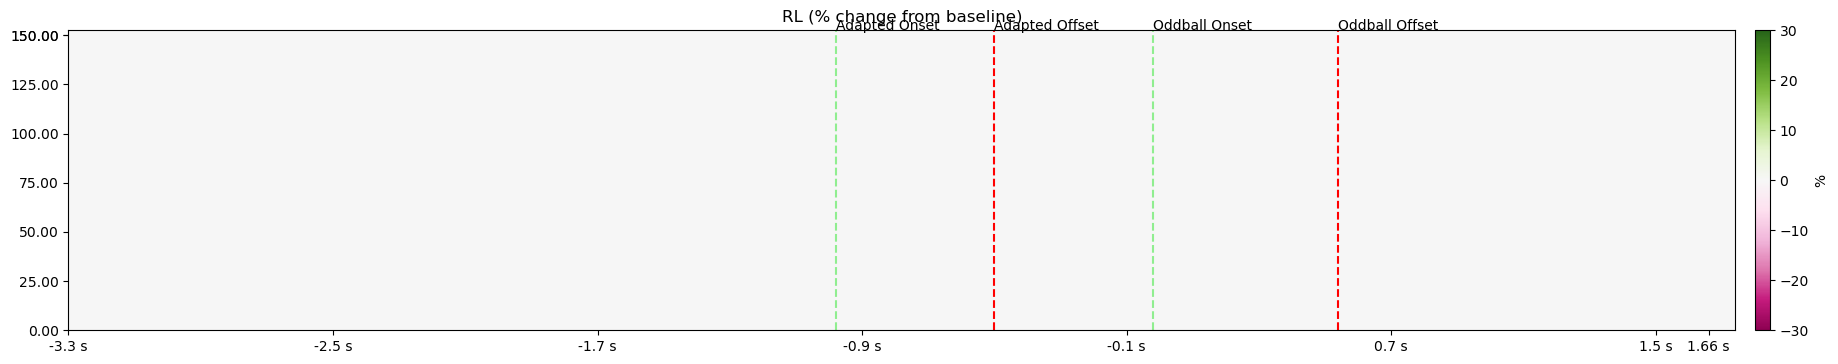

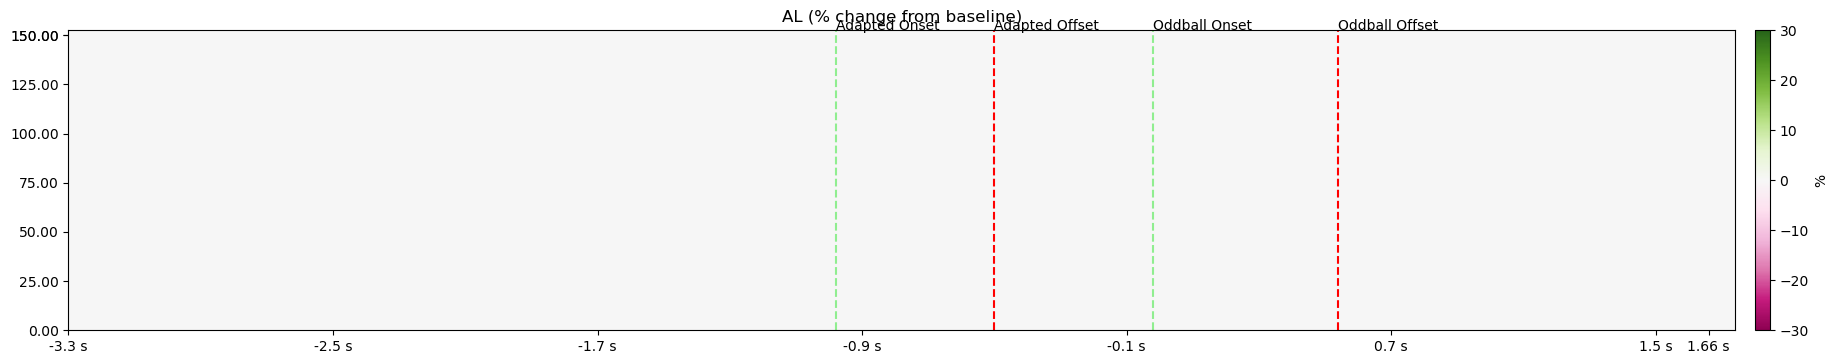

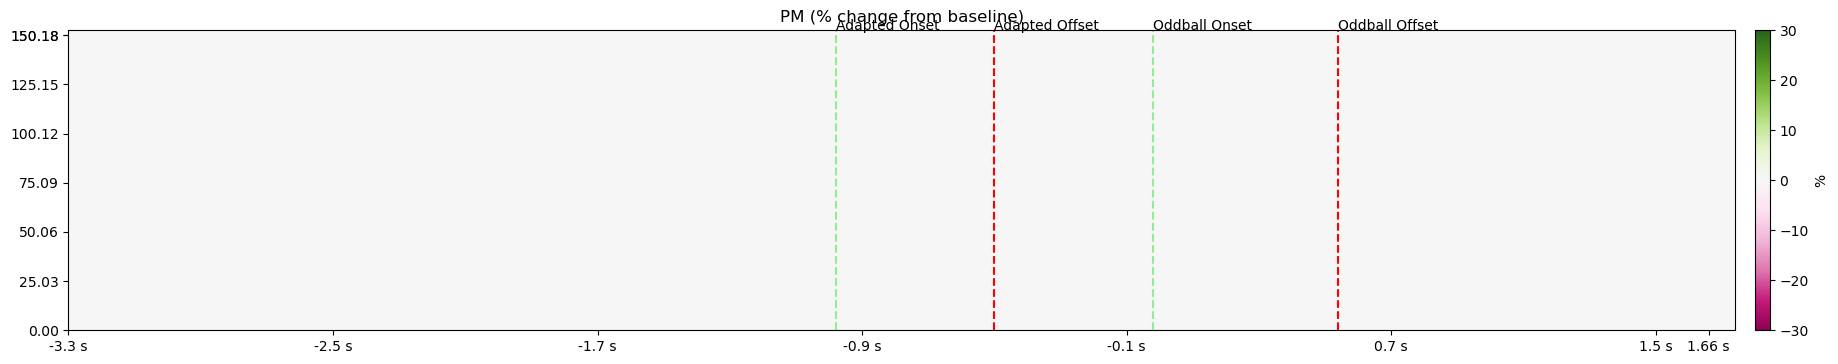

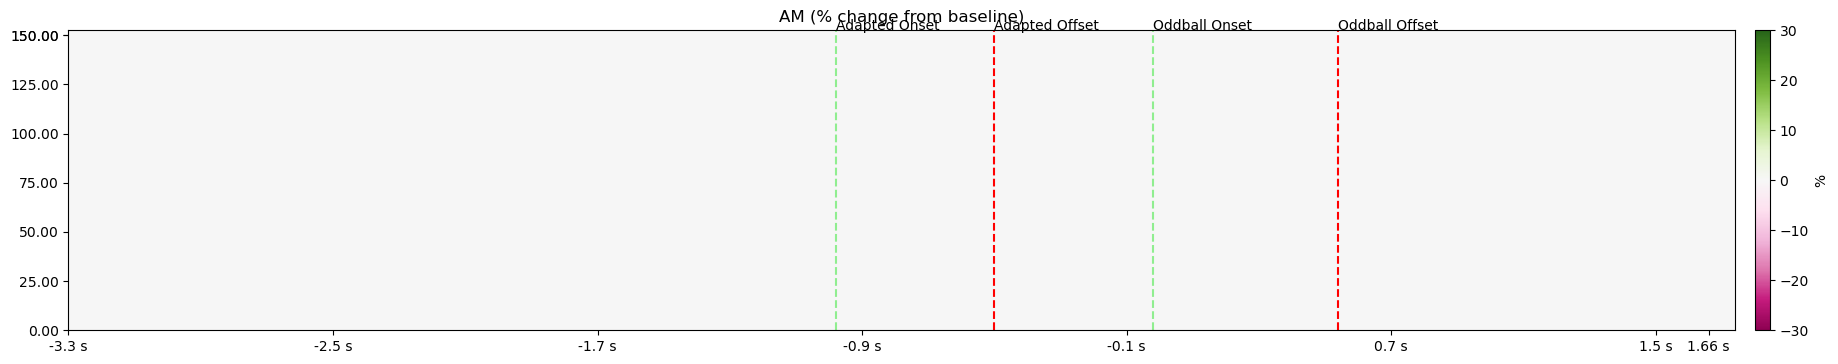

In [20]:
for area in anatomical_areas:
    contrast = contrasts["go_contrast"].stats[area].result()
    contrast['signal'].fmap(lambda data: data * contrast['mask']).heatmap(cmap='PiYG', title=stattitle(area, contrast['signal']), vmax=30, vmin=-30, **EVENTS)
    plt.show()